# TPS_Jun_2022_EDA_Imputation_Interpolation✨💦


# Imputation is the process of replacing missimg data with substituted values.
> * If data is missing, it can be resolved in several ways. 
> * The type of missing data are missing completely at random(MCAR), missing at random(MAR) and missing not at random(MNAR).

1. Listwise(complate case) deletion : : missing valie removal
1. Simple Imputer :: Univariate feature imputation: using only non_missing values(mean, median, most frequent or const) in feature dimension.)
1. Iterative Imputer :: Multivariate feature imputation: uisng the estimate for imputation.
1. KNN Imputer(K-Nearest Neighbor imputation) :: Using the weighted or unweighted mean value of the k nearest-neighbor columns)


In [ ]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pathlib import Path
from tqdm import tqdm

import xgboost as xgb

input_path = Path('/kaggle/input/tabular-playground-series-jun-2022/')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

In [ ]:
data = pd.read_csv(input_path / 'data.csv', index_col='row_id')

In [ ]:
data.head(10)

In [ ]:
data.info()

* There are missing values in float type data.

In [ ]:
features_f = [f for f in data.columns if data[f].dtype == 'float64' ]
features_i = [f for f in data.columns if data[f].dtype == 'int64' and f != 'id']

In [ ]:
def check(df):
    col_list = df.columns.values
    rows = []
    for col in col_list:
        tmp = (col,
              data[col].dtype,
              data[col].isnull().sum(),
              data[col].count(),
              data[col].nunique(),
              data[col].unique())
        rows.append(tmp)
    df = pd.DataFrame(rows) 
    df.columns = ['feature','dtype','nan','count','nunique','unique']
    return df

In [ ]:
check(data[features_i])

* We can see that the data does not contain missing values,

In [ ]:
check(data[features_f])

* We can see that the data contains missing values.

+++++++++++++++++++++++++++++++++++
# Missing Values
* Sometimes missing values occur. Understanding why data is missing is important for proper handring of the data.

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(data[features_f].isnull(), cmap = 'Reds')
plt.show()

* This missing data seems to be random.

In [ ]:
#Using the indicater
from sklearn.impute import MissingIndicator

indicator = MissingIndicator(features='all').fit_transform(data)
display(indicator)

* the indicator can also represent missing data with boolean.

In [ ]:
display(data.isna().sum())

* pandas.isna(object): Object to check for null or missing values and return a scaler boolean.

In [ ]:
percent = []
for i in range(data[features_f].shape[1]):
    n_miss = data[features_f[i]].isna().sum()
    perc = n_miss / data.shape[0] * 100
    percent.append(perc)
    
df_p = pd.DataFrame({'missing %' : percent}) 
df_p

In [ ]:
na_counts = pd.DataFrame([data.isna().mean()]).T
na_counts = na_counts.rename(columns = {0:'data_missing'})

na_counts.query('data_missing > 0').plot( kind = 'barh', figsize = (8,12), title = '% of values Missing')
plt.legend(bbox_to_anchor = (1.15,1) ,loc = 'best')
plt.show()

In [ ]:
na_counts

* Approximately 1.8% of all data is missing data.
* generally, if the percentage of missing values is less than 10%, the listwise deletion is considered effective for processing miising values.

In [ ]:
data['n_missing'] = data[features_f].isna().sum(axis = 1)
data['n_missing']

In [ ]:
data['n_missing'].value_counts()

* Some of the data also apper to have up to 9 missing values.

In [ ]:
data['n_missing'].value_counts().sum()

* the sum of missing values is one million(1000000).

In [ ]:
# the rows with NaN
data_ = data[features_f]
data_ = data_[data_.isna().any(axis = 1)]
data_

* The number of rows with missing values is 635226.

In [ ]:
data['n_missing'].value_counts().plot( kind = 'bar', title = 'Number of missing Values per data')

plt.show()

In [ ]:
data.query('n_missing == 8')

In [ ]:
#data.query('n_missing == 9')

In [ ]:
data.query('n_missing == 9').plot( kind = 'barh', figsize = (20,25), title = 'Missing')
plt.legend(bbox_to_anchor = (1.15,1) ,loc = 'best')
plt.show()

In [ ]:
data.groupby('F_1_2')['n_missing'].mean()

* Using groupby to display missing value of each feature.
* reference💡:(Abhishek Thakur with Rob Mulla) :https://www.youtube.com/watch?v=EYySNJU8qR0

++++++++++++++++++++++++++++++++++++++

In [ ]:
# Histograms of the integer features
plt.figure(figsize=(22, 22))

for i, f in enumerate(features_i):
    plt.subplot(5, 5, i+1)
    axs = sns.countplot(x = data[f])
plt.suptitle('Histograms of the integer features',fontsize = 18)
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(14, 4, figsize=(20, 66))
for f, ax in zip(features_f, axs.ravel()):
    ax.hist(data[f], density=True,bins=50)
    ax.set_title(f'data {f}, mean={data[f].mean():.4f},median={data[f].median():.4f}')

plt.legend()
plt.show()

* These are almost symmetrical graphs.

In [ ]:
data.iloc[:, 0:-1].describe().T.sort_values(by='mean', ascending=False) .style.background_gradient(cmap='gist_earth')

* F_4_11 is different from the other values(-26.2 ~ 31.2)
* F_4_x seems different from the other patterns.(e.g. a higher median)

In [ ]:
# memory reduce
for col in data.columns:
    if data[col].dtype == "float64":
        data[col]=pd.to_numeric(data[col], downcast="float")
    if data[col].dtype == "int64":
        data[col]=pd.to_numeric(data[col], downcast="integer")
        

* Memory deducts process was performed due to the large amount of data. 

In [ ]:
data.info()

* The feature's columns. is 81. 'n_missing' has been added. 😅 We should always check data before we do anything.

+++++++++++++++++++++++++++
# Submission

In [ ]:
submission = pd.read_csv(input_path / 'sample_submission.csv', index_col='row-col')
submission.head(10)

* sample submission's row_col is disorganized.

+++++++++++++++++++++++++++++++

In [ ]:
data_1 = data.copy()
submission_1 = submission.copy()

#data_2f = data[features_f].copy()
#data_2i = data[features_i].copy()
data_2 = data.copy()
submission_2 = submission.copy()


# Simple Imputation
* SimpleImputer is basic strategies for imputing missing values.
> *  Sklearn.SimpleImputer of parameter
> 1. missing_value: (int float,str,np.nan,None), default=np.nan
> 1. strategy: str('mean','median','most_frequent','constant') , default='mean'

reference💡: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

# mean? median? most frequent?
> * mean is avarage(the sum of values divided by the number of values)
> * median is middle value saparating the greater and lesser(50%)
> * mod is most frequent value.

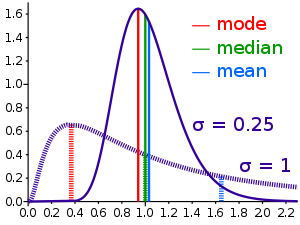

Comparsion of mean, median, mode of two lognormal distributions with diffrent skewness.
reference💡: wiki

In [ ]:
d1 = pd.Series( data[features_f].mean())
d2 = pd.Series( data[features_f].median())

sd = pd.Series(data[features_f].std())

In [ ]:
ax = sns.kdeplot(d1, color = 'g')
plt.legend(loc='upper right')
plt.show()

In [ ]:
ax = sns.kdeplot(d2, color = 'g')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Person's second skewness coefficient(median skewness)
ds = (( d1 - d2) *3) / sd
ds

In [ ]:
sns.kdeplot( data = ds) 
plt.show()

In [ ]:
pd.DataFrame({'mean': d1,'median': d2,'std':sd,'median_skewness': ds})

> * Skewness is a mesure of the asymmetry of the probability distribution. distribution can have right(or positive),left(or nrgative), or zero skewness.
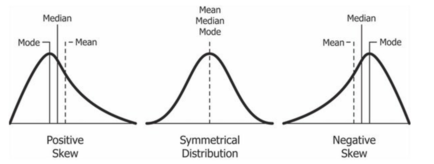

reference💡: skew (wiki)

In [ ]:
dd = data[features_f].loc[0:55].median()
dm = data[features_f].loc[0:55].mean()

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(dm[:55], color = 'r', label = 'mean')
plt.plot(dd[:55], color = 'g',label = 'median')
plt.axhline(y = 0.0, color='b',linestyle = '-', label = 'sample_submission')
plt.xticks(rotation= 90)
plt.legend(loc='upper center')
plt.show()

* This graph shows the mean and median values for each feature.

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:

imp_1 = SimpleImputer(
        missing_values=np.nan,
        strategy='mean',
        )

data_1[:] = imp_1.fit_transform(data_1)


In [ ]:

for i in tqdm(submission.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    submission_1.loc[i, 'value'] = data_1.loc[row, col]


In [ ]:
submission_1.to_csv("submission_1.csv")
submission_1.tail()

* This result is an obvious consequence,the same as the mean value of the float feature, and the median value is also the same. but, mean's score is better than median's score.

In [ ]:
sns.kdeplot( data = submission_1['value'])  
plt.show()

In [ ]:
plt.figure(figsize=(10, 12))
sns.countplot(y = submission_1['value'])
              
plt.legend()
plt.show()

+++++++++++++++++++++++++++++
# RMSE
* RMSE(Root-mean-square deviation or error) is the square root of the average of squared errors. it is always non-negative and a lower RMSE is better. 
* reference💡: https://en.wikipedia.org/wiki/Root-mean-square_deviation

In [ ]:
# exsample
from sklearn.metrics import mean_squared_error

true = [12,15,11,14,11,13,11]
pred = [12,14,12,14,11,12,11]

mse = mean_squared_error(true, pred)
rmse = mean_squared_error(true, pred , squared=False)
print('MSE is ', mse)
print('RMSE is ', rmse)

+++++++++++++++++++++++++++++++
# Trivia time ☕
* AC(Alternating current, AC waveform) is sine wave, the relationship between amplitudes(peak-to-peak) and RMS are fixed for any continous periodic wave.
* Root mean square voltage is the square root of the mean over one cycle of the square of the instantaneous voltage.
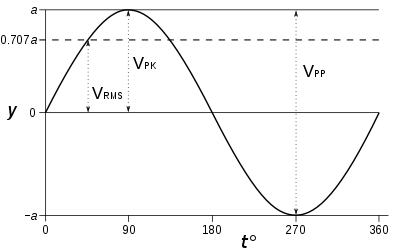
* reference💡: https://en.wikipedia.org/wiki/Alternating_current

+++++++++++++++++++++++++++
# Iterative Imputation
* Multivariate imputer that estimates each feature from all the others. Using regression problem where missing values are predicted.
> sklearn.IterativeImputer of paramaters 
> > 1. estimatores : default=BayesianRidge.
> > 1. missing_values : int or np.nan, default=np.nan,
> > 1. max_iter : int, default=10
> > 1. n_nearest_features : int, default=None
> > 1. initial_strategy{‘mean’, ‘median’, ‘most_frequent’, ‘constant’}: default=’mean’
> > 1. imputation_order{‘ascending’, ‘descending’, ‘roman’, ‘arabic’, ‘random’}: default=’ascending’
> > > * 'ascending': From features with fewest missing values to most.
> > > *'descending': From features with most missing values to fewest.
> > > *'roman': Left to right.
> > > *'arabic': Right to left.
> > > *'random': A random order for each round.
> > 1. random_state: int, RandomState instance or None,default=None
> > 1. add_indicator: bool, default=False


* reference💡 :https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

In [ ]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
seed = 2022
Max_Iter = 5

params = {
        'n_estimators' : 150,
         'random_state' : seed,
        'tree_method' : 'gpu_hist'
         }

In [ ]:

imputer = IterativeImputer(estimator = xgb.XGBRegressor(**params),
                           missing_values = np.nan,
                           max_iter = Max_Iter, # default = 10
                           initial_strategy = 'mean',
                           imputation_order = 'descending', # asending
                           verbose = 1, # 0,1, or 2
                           random_state = seed 

                          )
data_2[:] = imputer.fit_transform(data)


In [ ]:

for i in tqdm(submission_2.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    submission_2.loc[i, 'value'] = data_2.loc[row, col]


In [ ]:
submission_2.to_csv("submission_2.csv")
submission_2.head(10)

In [ ]:
sns.kdeplot(data = submission_2['value'])
plt.show()

* Imputation_order: descending is better than ascending.

++++++++++++++++++++++++++++++++++++
# Pandas.DataFrame.Interpolate(or Series.interpolate)
* Interpolate is filling in NaN in Series via liner interpolation.
* Iterpolation is the method of finding new data points based on the range of discrete set of known data points.
* It estimate the mean of the dependent variable.
* y = y1 + (x -x1)* ((y2 - y1)/(x2 - x1))

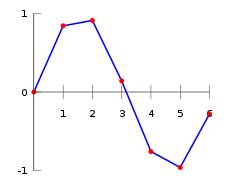
* In some cases, NaN at the bottom or the top or the leftnost or the rightmost is unchanged. 
* If NaNs are consecutive, you can specify the maximum number of interpolation with the argument limit. The default is None, which means that all consecutive NaNs are interpolated.
* parameter method:‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘spline’, ‘barycentric’, ‘polynomial’
* limit_direction:'forward',backward', 'both'
* limit_area : 'inside','outside' 
* reference💡:https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html


In [ ]:
d_2 = data.iloc[2, 0:80]
dm_2 = data.loc[0:80].mean()


In [ ]:
d_2,dm_2,dm

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(dm_2[0:80], color = 'r' , label = 'mean')
plt.title('row_id 2')
plt.xticks(rotation= 90)
plt.plot(d_2, label = 'values')
plt.legend()
plt.show()

In [ ]:
d_ip_2 = d_2.interpolate()

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(d_ip_2[:80], label = 'data[float_features]\'s values with an integer feature')
plt.plot(dm_2[:80], color = 'r', label = 'mean')
plt.plot(d_ip_2[2:3], marker='D', color = 'g' , markersize=15, label = 'interpolte(F_1_2)')
plt.plot(d_ip_2[67:68], marker='D', color = 'g' ,markersize=15,label = 'interpolte(F_4_2)')
plt.xticks(rotation= 90)
plt.legend(loc='upper left')
plt.show()

In [ ]:
data.query('n_missing == 9')

In [ ]:
def interpolate_(row_id):
    data_m = data[features_f].iloc[row_id, 0 :55]
    if data['n_missing'].iloc[row_id] > 0:
        data_i = data_m.interpolate(method = 'linear', limit = 7, limit_direction = 'both')
    return  data_i

In [ ]:
d_40610_ip = interpolate_(40610)
d_40610_ip

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(data[features_f].iloc[40610, 0:55],label = 'data[float_features]\'s value',linewidth = 3.5)
plt.plot(dm[:55], color = 'r', label = 'mean')
plt.plot(dd[:55], color = 'g',label = 'median')
plt.plot(d_40610_ip, label = 'interpolate')
plt.xticks(rotation= 90)
plt.legend(loc='upper center')
plt.show()

In [ ]:
d_273292_ip = interpolate_(273292)
d_273292_ip

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(data[features_f].iloc[273292, 0:55],label = 'data[float_features]\'s value',linewidth = 3.5)
plt.plot(dm[:55], color = 'r', label = 'mean')
plt.plot(dd[:55], color = 'g',label = 'median')
plt.plot(d_273292_ip, label = 'interpolate')
plt.xticks(rotation= 90)
plt.legend(loc='upper center')
plt.show()

In [ ]:
d_f310 = data['F_3_10']
d_f310_me = data['F_3_10'].mean()
d_f310_md = data['F_3_10'].median()
d_f310_ip = d_f310.interpolate(method = 'linear', limit = 5, limit_direction = 'both')


* I tried to select one part of the feature and checked their relevance.

In [ ]:
d_f310_me,d_f310_md

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(d_f310[50:200],linewidth = 3.5,label='original')
plt.plot(d_f310_ip[50:200], label = 'interpolate')
plt.axhline(d_f310_me, color = 'r', label = 'mean')
plt.xticks(rotation= 90)
plt.legend(bbox_to_anchor = (1.15,1) ,loc = 'best')
plt.show()

In [ ]:
data_= data[features_f]
data_ = data_[data_.isna().any(axis = 1)]
data_

In [ ]:
def interpolate_1(row_id):
    data_m_ = data_.iloc[row_id, 0 :55]
    data_i = data_m_.interpolate(method = 'linear', limit = 7, limit_direction = 'both')
    return  data_i

In [ ]:
data_.columns

In [ ]:
data_.index

In [ ]:
df = pd.DataFrame(data_)
for i in tqdm(data_.index[0:400000]):
    inter = interpolate_1(i)
    df.loc[i] = interpolate_1(i)

In [ ]:
df.head(20)

* It look like it interpolated well.😉
* Data id 40610 which has 9 missing data,the line between F_3_0 and F_3_4 (continuous missing)is shaped like a mountain.
* Maybe some peak point of the missing value is higher(lower) than mean, median or interpolation.
* It seems we need to find other way to get closer to the actual data.
* I tried this method of working it out somehow,~but the calculation of the relevant rows took too long and ran out of memory,so I gave up this time. May be a little something(idea 💡) needs to be done.~
* Unfortunately, at some point an error occurred and I could not get the result.😥

+++++++++++++++++++++++++++++++++
# Summary
* By separating the Data types,time was cut in half.
* F_2_0...F_2_24(Integer) : no missing data.  This mean it dosen't need imputation.
* update: This time,I have tried only float type data. ~The result(score) was the same,however this model is not the same as the avarage value of the float feature.~
* In float only, Simple imputation's results wes the same as original(float and integer)feature's result.
* Iterative imputation with XGB in original(float and integer)featuer's results takes more time, but the score is better.
*  For better results, I need to try some methods used with integer data or something...


+++++++++++++++++++++++++++++++++++
# Conclusion
* The disadvantages of incomplate data with missing values that statistical processing is impossible.
* With incomplate data, if missing values are removed, the results of analysis will be biased and must be prenvented. 
* Missing value handling methods
> 1. Simple imputation(e.g. mean value assignment method)
> 1. Iterative imputation(With regression problem where missing values are predicted)
> 1. K-NN(k-nearest neighbor algorithm) is classification method using multiple voting based on adjacent data in the features.
> 1. Iterpolation(Estimate the mean of the dependent variable)
* In this case,, the data was incomplate (one million digits). so I tried to figure out how to make it more effcient and faster.



Thank you for reading! Good Luck!
* ~in progress....🚧~